# Facial Features Measurement & Analysis

<h3>Conclusion:</h3>
<h4><b>Measure 19 facial features using basic geometry equations, and produce scaled measurements in pixels</b></h4>

<h4><b>Note:</b></h4>
<p>
    Some improvements are applied to the landmarks detection, for more information visit <a href="https://www.kaggle.com/zeyadkhalid/full-face-81-landmarks-detection-highly-improved" target="_blank">(this)</a> notebook
</p>

<h3>Features Visual Description</h3>
<img src="https://user-images.githubusercontent.com/50156227/140836123-92d5e97f-059a-437a-ba63-56d95664f667.png" height="480">

<h3>Features Textual Description:</h3>
<ol>
    <li>
        <b>Forehead Height</b>: distance between the top edge of eyebrows and the top edge of forehead.
    </li>
    <li>
        <b>Middle Face Height</b>: distance between the top edge of eyebrows and nose tip.
    </li>
    <li>
        <b>Lower Face Height</b>: distance between nose tip and the baseline of chin.
    </li>
    <li>
        <b>Jaw Shape</b>: A number to differentiate between jaw shapes. this number can be replaced if you use Face Shape Recognition, see <a href="https://www.kaggle.com/zeyadkhalid/face-shape-recognition-73-accuracy" target="_blank">(this)</a> notebook.
    </li>
    <li>
        <b>Left Eye Area</b>
    </li>
    <li>
        <b>Right Eye Area</b>
    </li>
    <li>
        <b>Eye to Eye Distance</b>: distance between eyes (closest edges)
    </li>
    <li>
        <b>Eye to Eyebrow Distance</b>: distance between eye and eyebrow (left or right is determined by whice side of the face is more directed to the -screen-)
    </li>
    <li>
        <b>Eyebrows Distance</b>: horizontal distance between eyebrows
    </li>
    <li>
        <b>Eyebrow Shape Detector 1</b>: The angle between 3 points (eyebrow left edge, eyebrow center, eyebrow right edge), to differentiate between (Straight | Non-straight) eyebrow shapes
    </li>
    <li>
        <b>Eyebrow Shape Detector 2</b>: A number to differentiate between (Curved | Angled) eyebrow shapes.
    </li>
    <li>
        <b>Eyebrow Slope</b>
    </li>
    <li>
        <b>Eye Slope Detector 1</b>: A method to calculate the slope of the eye. it's the slope of the line between eye's center point and eye's edge point. this detector is used to represent 3 types of eye slope (Upward, Downward, Straight).
    </li>
    <li>
        <b>Eye Slope Detector 2</b>: Another method to calculate the slope of the eye. it's the difference on Y-axis between eye's center point and eye's edge point. this detector isn't a 'mathematical' slope, but a number that can be clustered into 3 types of eye slope (Upward, Downward, Straight).
    </li>
    <li>
        <b>Nose Length</b>
    </li>
    <li>
        <b>Nose Width</b>: width of the lower part of the nose
    </li>
    <li>
        <b>Nose Arch</b>: Angle of the curve of the lower edge of the nose (longer nose = larger curve = smaller angle)
    </li>
    <li>
        <b>Upper Lip Height</b>
    </li>
    <li>
        <b>Lower Lip Height</b>
    </li>
</ol>
<h3><b>Inspirational Ideas</b></h3>
<ul>
    <li>Emotion Recognition from facial features</li>
    <li>Face Identification / Authentication</li>
    <li>Detect personality traits from facial features</li>
    <li>Gender Classification</li>
    <li>Down Syndrome Detection</li>
    <li>In General: use it as a preprocessing step to study the relation between numeric data instead of images</li>
</ul>
<h3>Any Suggestions?</h3>
<p>What else would be useful to measure? face width? mouth width (for smile detection)? distance between eyes and mouth? let me know your thoughts and I'll try to apply in a notebook update</p>

In [1]:
! pip install imutils

import os
import math
import cv2
import dlib
import numpy as np
import pandas as pd
from imutils import face_utils
import matplotlib.pyplot as plt

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=0e4758202cbbba43afab2e97a4222afcf3e6c381917207bf719d48d7b6004190
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
# Define mathematics functions

def equation1(points):
    # This method is a part of Eyebrows shape detector
    # Use shape_predictor_68 as a reference for points
    # points = [22,23,24,25,26]  (right eyebrow) - (method works for left eyebrow too)
    avgPoint = [np.average(points[[2,3],0]), np.average(points[[2,3],1])]
    angle = angle_of_3points(avgPoint,points[1],points[4])
    result = angle
    return result

def equation2(points):
    # This method is a part of Eyebrows shape detector
    # Use shape_predictor_68 as a reference for points
    # points = [22,23,24,25,26]  (right eyebrow) - (method works for left eyebrow too)
    result = slope(points[3], points[4])
    if result == "inf" or result == 0 :
        return 1
    return result

def equation3(points):
    # This method is a part of Eyebrows shape detector
    # Use shape_predictor_68 as a reference for points
    # points = [22,23,24,25,26]  (right eyebrow) - (method works for left eyebrow too)
    result = slope(points[1], points[2], True)
    if result == "inf" :
        result = 0
    x1,y1 = points[3]
    x2,y2 = points[4]
    slope2 = slope(points[3], points[4], True)
    if slope2 == "inf" :
        slope2 = 0
    result += slope2
    result = 1 if result == 0 else result
    return result


def equation4(points):
    # This method is a part of Eyebrows shape detector
    # Use shape_predictor_68 as a reference for points
    # points = [22,23,24,25,26]  (right eyebrow) - (method works for left eyebrow too)
    total = np.array([])
    for i in range(len(points)-2):
        total = np.append(total, (points[i+1,1] - points[i,1]))
        
    differences = abs(total[1]-total[0]) + abs(total[2] - total[1])
    
    slope0 = slope(points[0], points[1], True)
    slope1 = slope(points[2], points[3])
    slope2 = slope(points[3], points[4], True)
    
    slope0 = 1 if (slope0 == 0 or slope0 == "inf") else slope0    
    slope1 = 1 if (slope1 == 0 or slope1 == "inf") else slope1
    
    differences = 1 if differences == 0 else differences
    
    result = slope2 * (0.5*slope1/slope0) * (5/differences)
    result = 1 if result == 0 else result
    return result



# Function to calculate area of any shape given its points coordinates
def shape_area(points, circularArray=False):
    # Circular array means that first point is added to the end of the array    
    result = 0
    for i in range(len(points)-1):
        x1,y1 = points[i]
        x2,y2 = points[i+1]
        result += (x1*y2) - (y1*x2)
    if not circularArray:
        x1,y1 = points[len(points)-1]
        x2,y2 = points[0]
        result += (x1*y2) - (y1*x2)
    result /= 2
    return abs(result)


# Function to get the angle of three points
def angle_of_3points(p1,p2,p3):
    # NOTE : p1 is the middle point
    radian = math.atan2(p3[1] - p1[1], p3[0] - p1[0]) - math.atan2(p2[1] - p1[1], p2[0] - p1[0])
    degrees = math.degrees(abs(radian))
    return degrees

def slope(point1, point2, absolute=False):
    x1,y1 = point1
    x2,y2 = point2
    deltaX = x2-x1
    deltaY = y2-y1
    if deltaX == 0:
        return "inf"
    slope = deltaY / deltaX
    if absolute:
        slope = abs(slope)
    return round(slope,3)


# Function to calculate the difference between 2 points on Y-axis
def diff_Yaxis(point1,point2):
    return round(point1[1] - point2[1],3)

# Function to calculate the coordinates of the center of the eye
def eyeCenter(points):
    p1,p2,p3,p4 = points
    x = np.average([p1[0],p2[0],p3[0],p4[0]])
    y = np.average([p1[1],p2[1],p3[1],p4[1]])
    return np.array([x,y])

# Function to calculate the gradient difference in Y-axis for a group of points
def sum_difference(points):
    result = 0
    for i in range(points.shape[0]-1):
        result += diff_Yaxis(points[i], points[i+1])
    return round(result,3)


# Function to calculate the sum of slopes of a group of points
def sum_slopes(points, absolute=False):
    result = 0
    for i in range(points.shape[0]-1):
        _slope = slope(points[i], points[i+1], absolute)
        if _slope == "inf":
            continue
        result += _slope
    return round(result,3)

In [3]:
# Define helper functions

def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            filenames.append(filename)
    return images, filenames

In [4]:
# Computer Vision functions

predictor68 = dlib.shape_predictor('../input/shape-predictor-68-face-landmarks/shape_predictor_68_face_landmarks.dat')
predictor81 = dlib.shape_predictor('../input/shape-predictor81/shape_predictor_81_face_landmarks.dat')

# Function to determine the color range allowed to move landmarks points through image
def getAllowedColorRange(avgSkinColor):
    # Dark skin
    if (avgSkinColor < 100):
        colorRange = (avgSkinColor-35, avgSkinColor+50)
    # Somehow dark skin
    elif(avgSkinColor <= 130): 
        colorRange = (avgSkinColor-30, avgSkinColor+30)
    # Normal skin color (tends to dark)
    elif(avgSkinColor <= 160):
        colorRange = (avgSkinColor-40, avgSkinColor+40) 
    # Normal skin color 
    elif(avgSkinColor < 180):
        colorRange = (avgSkinColor-50, avgSkinColor+50)
    # Normal skin color (tends to white)
    elif(avgSkinColor < 210):
        colorRange = (avgSkinColor-50, avgSkinColor+30) 
    # white skin color
    elif (avgSkinColor < 230):
        colorRange = (avgSkinColor-40, avgSkinColor+20)
    # Abnormal white skin color
    else:
        colorRange = (avgSkinColor-30, avgSkinColor+15)
    return colorRange

# Function to move landmarks points, based on skincolor
def moveUp(grayscale_image, point, avgSkinColor, foreheadHeight):
    # Get color range & current color where the point is located in image
    steps = 5
    portionOfOriginalPointY = 0.275
    originalPoint = np.copy(point)
    colorRange = getAllowedColorRange(avgSkinColor)
    currentPixelColor = grayscale_image.item(point[1],point[0])
    
    # move the landmark point up until a strong change of color happen (outside color range)
    while currentPixelColor > colorRange[0] and currentPixelColor < colorRange[1]:
        
        # If point is going out of image boundary
        if point[1] < 0:
            # Get back to original point location, with a little bit higher
            point[1] = originalPoint[1] - (originalPoint[1] * portionOfOriginalPointY)
            break
            
        # move up (N steps) pixels & get the color
        point[1] = point[1] - steps
        
        currentPixelColor = grayscale_image.item(point[1],point[0])
        
    # if the pixel is moved too high than expected (3/4 forehead height): keep close to original
    if abs( originalPoint[1] - point[1] ) > ( foreheadHeight * 0.75 ):
        point[1] = originalPoint[1] - (originalPoint[1] * portionOfOriginalPointY)
    return point

# Function to detect if the forehead is clear or covered with hair (it corrupts the enhancement of landmarks points)
def clearForehead(forehead, avgSkinColor):
    clarityThreshold = 85
    colorRange = getAllowedColorRange(avgSkinColor)
    
    # Check if most of the forehead is the same as skin color
    regionOK = np.logical_and(forehead > colorRange[0] , forehead < colorRange[1])
    try:
        percentage = (np.count_nonzero(regionOK) / forehead.size) * 100
    except:
        return False
    isClear = True if percentage >= clarityThreshold else False
    return isClear


# Function to perform facial landmark detection on the whole face
def facial_landmarks(image, eyeOnlyMode=False, allowEnhancement=False):
    # ARGUMENTS:
    # - eyeOnlyMode: detect & return eye landmarks, used to align face
    # - allowEnhancement: allow improvement (landmarks repositioning)
    
    # Return:
    # - NumPy array of coordinates of landmarks
    
    # Use dlib 68 & 81 to predict landmarks points coordinates
    detector = dlib.get_frontal_face_detector()
    global predictor68
    global predictor81
    
    # Grayscale image
    try:
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except:
        grayscale_image = image
    
    # array of rectangles surrounding faces detected
    rectangles = detector(grayscale_image, 1)

    # If at least one face is detected   
    if len(rectangles) > 0:
        # Get 68 landmark points
        faceLandmarks = predictor68(grayscale_image, rectangles[0])
        faceLandmarks = face_utils.shape_to_np(faceLandmarks)
        
        if eyeOnlyMode:
            # Return eye points to perform a calculated rotation
            return np.array([faceLandmarks[39], faceLandmarks[42]])
        
        # Get 81 landmark points
        foreheadLandmarks = predictor81(grayscale_image, rectangles[0])
        foreheadLandmarks = face_utils.shape_to_np(foreheadLandmarks)
        
        # Get 68 point from -68- predictor (higher accuracy) + forehead from -81- predictor
        fullFacePoints = np.concatenate((faceLandmarks, foreheadLandmarks[68:]))
        
        # Get forehead region & height to perform simple improvement
        x,y,x2,y2 = (fullFacePoints[69,0]-10, fullFacePoints[68,1], fullFacePoints[80,0]+10, fullFacePoints[23, 1])
        foreheadRegion = grayscale_image[y:y2,x:x2]
        foreheadHeight = foreheadRegion.shape[0]
        
        if allowEnhancement:
            # Perform progressive quality improvement
            # Get nose region to get average skin color
            x,y,x2,y2 = (fullFacePoints[28,0]-5, fullFacePoints[28,1], fullFacePoints[28,0]+5, fullFacePoints[30,1])
            noseRegion = grayscale_image[y:y2, x:x2]
            avgSkinColor = np.average(noseRegion[:,:])
            
            # Check if forehead is clear -> perform heuristic based enhancement
            forehead_is_clear = clearForehead(foreheadRegion, avgSkinColor)
            originalPoints = fullFacePoints[[69,70,71,73,80]]
            
            if forehead_is_clear:
                avgSkinColor = np.average(foreheadRegion)
                
                # Modify some points for more accuracy
                # Point[68] will be center between lower-lip & chin
                distance = int((fullFacePoints[8,1]-fullFacePoints[57,1]) / 2)
                fullFacePoints[68] = np.array([fullFacePoints[8,0], fullFacePoints[8,1]-distance])
                
                # Enhance points locations
                enhancedPoints = np.array([moveUp(grayscale_image, orgPoint, avgSkinColor, foreheadHeight) for orgPoint in originalPoints])

                # Assign original points to enhanced points (some maybe the same)
                fullFacePoints[[69,70,71,73,80]] = enhancedPoints  
                
                # Adjust points to fix any corruptions
                fullFacePoints[[69,70,71,73,80]] = adjustPoints(enhancedPoints, fullFacePoints[76], fullFacePoints[79])

                #Prepare point[72] for center of forehead
                distance = (fullFacePoints[22,0] - fullFacePoints[21,0]) / 2
                distanceY = (fullFacePoints[21,1] - fullFacePoints[71,1]) / 2
                fullFacePoints[72] = np.array([fullFacePoints[21,0] + distance, fullFacePoints[21,1]-distanceY])
                
                # Point[74] sometimes have a fixed corruption, this line helps :)
                fullFacePoints[74,0] -= foreheadHeight * 0.1 # Arbitery heurestic
                
            else:
                # If forehead isn't clear -> fix points with very simple heuristics
                fullFacePoints[70,1] -= foreheadHeight * 0.2
                fullFacePoints[71,1] -= foreheadHeight * 0.3
                fullFacePoints[80,1] -= foreheadHeight * 0.2
    
        else:
            # If Enhancement is False -> do the simple enhancement, better quality + low performance :)
            fullFacePoints[70,1] -= foreheadHeight * 0.2
            fullFacePoints[71,1] -= foreheadHeight * 0.3
            fullFacePoints[80,1] -= foreheadHeight * 0.2
            pass
        
        return fullFacePoints
    # No faces found
    else:
        return None

# Function to adjust landmarks points of the forehead 
# and fix corruptions of improvement (such as the bald man case)
def adjustPoints(points, leftSidePoint, rightSidePoint):    
    # Use shape_predictor_81 as a reference for points indexes to fix:
    # points = [69,70,71,73,80]
    # LeftSidePoint = 76  |  rightSidePoint = 79
    
    slopes = []
    slopeThreshold = 0.4 # slope > 0.4 = corruption -> fix
    totalSlopeThreshold = 1 # sum of slopes > 1 = corruption -> fix
    leftPoint = points[0]
    rightPoint = points[3]
    criticalLeftPoint = points[1]
    criticalRightPoint = points[4]
    
    # if any point is higher than a (accurate located point) -> fix
    if leftPoint[1] < criticalLeftPoint[1] :
        points[0,1] = np.average([criticalLeftPoint[1], leftSidePoint[1]])
    if rightPoint[1] < criticalRightPoint[1]:
        points[3,1] = np.average([criticalRightPoint[1], rightSidePoint[1]])
    
    # Collect some slopes of the usually corrupted points
    slopes.append(slope(points[1], points[2], True))
    slopes.append(slope(points[2], points[4], True))
    
    # Calculate slope differences & sum
    difference = abs(np.diff(slopes))
    _sum = np.sum(slopes)
    
    # If calculation results (either) too high = corruption -> fix
    if difference > slopeThreshold:
        issueIndex = np.argmax(slopes)
        if issueIndex == 0:
            points[1,1] = max(points[4,1], points[2,1])
        else:
            points[4,1] = max(points[1,1], points[2,1])
            
    if _sum > totalSlopeThreshold:
        points[1,1] = np.average(points[[4,2], 1])
        points[4,1] = np.average(points[[1,2], 1])
        points[2,1] = np.average(points[[4,1], 1])  
        
    return points

# Function to extract the whole face
def cropFullFace(image, points, padding = True, xProportion = 0.025, yProportion = 0.025):    
    imageShape = image.shape
    # Get borders of the 4 directions
    top = points[:,1].min()
    bottom = points[:,1].max()
    left = points[:,0].min()
    right = points[:,0].max()
    
    if padding:
        # X-factor is a an additional proportion of the image on X-axis, considered in the output 
        # Y-factor is the same for Y-axis 
        xFactor = int((xProportion) * imageShape[1])
        yFactor = int((yProportion) * imageShape[0])
        x,y,x2,y2 = (max(left-xFactor, 0), max(top-yFactor, 0) ,min(right+yFactor, imageShape[0]), min(bottom+yFactor, imageShape[0]) )
    
    else:
        x,y,x2,y2 = (left,top ,right, bottom )

    cropped = image[y:y2, x:x2]
    return cropped

# Function to rotate image to align the face
def align_face(image, eyePoints):
    # Get left eye & right eye coordinates
    leftEyeX,leftEyeY = eyePoints[0]
    rightEyeX, rightEyeY = eyePoints[1]

    # Calculate angle of rotation & origin point
    angle = math.atan( (leftEyeY - rightEyeY) / (leftEyeX - rightEyeX) ) * (180/math.pi)
    origin_point = tuple(np.array(image.shape[1::-1]) / 2)

    # Rotate using rotation matrix
    rot_mat = cv2.getRotationMatrix2D(origin_point, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result
    

# Function to collect landmarks points, grouped, as polygons
def collectFaceComponents(facial_points):
    faceShape = np.concatenate((facial_points[0:17],facial_points[[78,74,79,73,80,71,70,69,76,75,77,0]])) 
    leftEye = np.concatenate((facial_points[36:42],np.array([facial_points[36]])))
    rightEye = np.concatenate((facial_points[42:47],np.array([facial_points[42]])))
    leftIBrow = facial_points[17:22]
    rightIBrow = facial_points[22:27]
    noseLine = facial_points[27:31]
    noseArc = facial_points[31:36]
    upperLip = facial_points[[49,50,51,52,53,61,62,63]]
    lowerLip = facial_points[[55,56,57,58,59,65,66,67]]
    faceComponents = {
            "face_shape":faceShape,
            "left_eye":leftEye,
            "right_eye":rightEye,
            "left_i_brow":leftIBrow,
            "right_i_brow":rightIBrow,
            "nose_line":noseLine,
            "nose_arc":noseArc,
            "upper_lip":upperLip,
            "lower_lip":lowerLip
            }
    return faceComponents



# Geometrically analyze & measure facial features & return a Series of measurements
def measure_features(facial_points):    
    # Initialize facial features/components
    faceComponents = collectFaceComponents(facial_points)
    face_shape = faceComponents["face_shape"]
    leftEye, rightEye = faceComponents["left_eye"], faceComponents["right_eye"]
    left_ibrow, right_ibrow = faceComponents["left_i_brow"], faceComponents["right_i_brow"]
    nose_line, nose_arc = faceComponents["nose_line"], faceComponents["nose_arc"]
    upper_lip, lower_lip = faceComponents["upper_lip"], faceComponents["lower_lip"]
    
    # Features
    
#    forehead height, middle face height, lower face height,
#    jaw shape, left eye area, right eye area, eye to eye distance,
#    eye to eyebrow distance, upper lip height, lower lip height,
#    eyebrows distance, nose length, nose width, nose arc,
#    eyebrow detector1, eyebrow detector2,
#    eye slope detector1, eye slope detector2, eyebrow slope
        
    # Graphical points, to draw colored lines on each measured component
    graphical_points = {}
    
    # Forehead height (Distance from Top forehead Eyebrow)
    # Use 3 points & avg them, to reduce any position/coordinates errors
    threeMiddleXForeheadPoints = facial_points[[70,71,80]]
    averageY =  np.average(threeMiddleXForeheadPoints[:,1])
    
    # Top edge point of eyebrow
    middle_right_ibrow = right_ibrow[2,1]
    forehead_height = middle_right_ibrow - averageY  # << Final result
    
    graphical_points['forehead height'] = [ np.average(threeMiddleXForeheadPoints, axis=0).astype(int), np.average([left_ibrow[2], right_ibrow[2]], axis=0).astype(int) ]
    
    ##################################################################
    
    # Jaw width (as classes, not actual measurements)
    # Jaw Classes = Face shape = [Square, Round, Oval, Triangle, Heart, Oblong]
    measurement_1 = sum_slopes(face_shape[[8,9,10,11,12]], True)
    measurement_2 = sum_slopes(face_shape[[4,5,6,7,8]], True)
    measurement_3 = abs(sum_difference(face_shape[[8,9,10,11,12]]))
    measurement_4 = abs(sum_difference(face_shape[[4,5,6,7,8]]))
    
    # Find a relation between measurements to maximize margin between different classes
    jaw_width = (((measurement_1*measurement_3)/2) * ((abs(measurement_2)*abs(measurement_4))/2)) / 1000
    
    # Get angle of chin & jaw
    jaw_angle = angle_of_3points(face_shape[8],face_shape[5], face_shape[11])
    
    # Find a relation between jaw angle & jaw width
    jaw_class = (jaw_width / jaw_angle) * 100 # << Final result
    
#    graphical_points['jaw shape'] = [ face_shape[ [4,5,6,7,8,9,10,11,12] ] ]
    ##################################################################

    # Eyes Areas
    left_i_area = shape_area(leftEye) # << Final result
    right_i_area = shape_area(rightEye) # << Final result
    
    graphical_points['left eye area'] = leftEye
    graphical_points['right eye area'] = rightEye
    
    ##################################################################
    
    # eye to eye distance
    eye2eye_distance = np.min(rightEye[:,0]) - np.max(leftEye[:,0]) # << Final result
    
    graphical_points['eye to eye distance'] = [ leftEye[leftEye.argmin(axis=0)][0], rightEye[rightEye.argmin(axis=0)][0] ]
    
    ##################################################################
    
    # Eye to Eyebrow distance (left side + right side) / 2
    left_i2ibrow_distance = np.min(leftEye[:,1]) - left_ibrow[2,1]
    right_i2ibrow_distance = np.min(rightEye[:,1]) - right_ibrow[2,1]
    eye2eyebrow_distance = (left_i2ibrow_distance + right_i2ibrow_distance) / 2 # << Final result
    
    graphical_points['eye to eyebrow distance'] = [rightEye[2], right_ibrow[2]]
    
    ##################################################################
    
    # Lips height
    upper_lip_height = np.max(upper_lip[:,1]) - np.min(upper_lip[:,1]) # << Final result
    lower_lip_height = np.max(lower_lip[:,1]) - np.min(lower_lip[:,1]) # << Final result
    
    graphical_points['upper lip height'] = [ upper_lip[1], upper_lip[5] ]
    graphical_points['lower lip height'] = [ lower_lip[1], lower_lip[5] ]
    ##################################################################
    
    # Eyebrows distance (the space between eyebrows) 
    eyebrows_distance = right_ibrow[0,0] - left_ibrow[4,0] # << Final result
    
    graphical_points['eyebrows distance'] = [ right_ibrow[0] , left_ibrow[4] ]
    
    ##################################################################
    
    # Nose length
    nose_length = np.max(nose_line[:,1]) - np.min(nose_line[:,1]) # << Final result
    
    graphical_points['nose length'] = [ nose_line[0], nose_line[3] ]
    
    ##################################################################
    
    # Nose Width & Arc angle
    nose_width = nose_arc[4, 0] - nose_arc[0,0] # << Final result
    nose_arc_angle = angle_of_3points(nose_arc[2], nose_arc[0], nose_arc[4]) # << Final result
    
    graphical_points['nose width'] = [ nose_arc[4] , nose_arc[0] ]
    graphical_points['nose arc'] = [ nose_arc[0], nose_arc[2], nose_arc[4] ]
    
    ##################################################################
    
    # Middle-face height (from eyebrow edge to nose end)
    right_ibrow_y = right_ibrow[2,1]
    middle_face_height = nose_line[3, 1] - right_ibrow_y # << Final result
    
    graphical_points['middle face height'] = [ nose_line[3], np.average([left_ibrow[2], right_ibrow[2]], axis=0).astype(int) ]
    
    ##################################################################
    
    # Lower-face height (from nose tip to chin)
    face_bottom_y = np.max(face_shape[:,1])
    lower_face_height = face_bottom_y - nose_arc[2,1] # << Final result
    
    graphical_points['lower face height'] = [facial_points[8], nose_arc[2]]
    
    ##################################################################
    
    # Left / Right Eyebrow class: [Straight, Arched, Angled]
    lefteyeside = leftEye[3]
    righteyeside = rightEye[0]
    
    # Determine to measure left or right eyebrow, based on
    # distance between nose bottom-point & eyes angle-point 
    noseTip = nose_line[nose_line.shape[0]-1]
    nose_eye_diff = abs(noseTip[0]-lefteyeside[0]) - abs(noseTip[0]-righteyeside[0])
    ibrow_position = "right" if nose_eye_diff <= 3 else "left"
    clear_ibrow = faceComponents[ibrow_position+"_i_brow"]
    
    # If the clear eyebrow is left, reverse points order for correct results
    if ibrow_position == "left":
        clear_ibrow = clear_ibrow[::-1]
        
    # AngleX is the difference between straight eyebrows and other types
    angleX = angle_of_3points(clear_ibrow[2],clear_ibrow[0],clear_ibrow[4]) # << Final result(1)
 
    # arched_angled_EQ is the value representing difference between curved & angled eyebrows
    arched_angled_EQ = math.ceil(((equation1(clear_ibrow)) * (equation2(clear_ibrow)) * (equation3(clear_ibrow))) * (equation4(clear_ibrow)) / 100) # << Final result(2)
    
    
    graphical_points['eyebrow shape detector 1'] = [clear_ibrow[0], clear_ibrow[2], clear_ibrow[4]]
    graphical_points['eyebrow shape detector 2'] = right_ibrow if ibrow_position == 'left' else left_ibrow
    
    ##################################################################
    
    # Eye slope detectors

    # left/right eye slope
    lefteyecenter = eyeCenter(leftEye[[1,2,4,5]])
    righteyecenter = eyeCenter(rightEye[[1,2,4,5]])
    
    
    # Eye sides slopes shape: [Upward, Downward, Straight]
    lefteyeslope = slope(leftEye[0],lefteyecenter)
    righteyeslope = slope(righteyecenter,rightEye[3]) 
    
    
    # Eye sides difference (Difference on y-axis between eye edge-point & center point)
    lefteyediff = diff_Yaxis(leftEye[0],lefteyecenter)
    righteyediff = diff_Yaxis(righteyecenter, rightEye[3])
        
    # Left eye slope & diff, right eye slope & diff
    leftpair = (lefteyeslope*-1,righteyeslope)
    rightpair = (lefteyediff,righteyediff*-1)
    totalpair = np.add(leftpair,rightpair)
    
    eyeSlopeDetector1 = totalpair[0] # << Final result(1)
    eyeSlopeDetector2 = totalpair[1] # << Final result(2)
    
    graphical_points['eye slope detector1'] = [ leftEye[0], leftEye[3] ]
    graphical_points['eye slope detector2'] = [ rightEye[0], rightEye[3] ]
    
    ##################################################################
    
    # Left or Right eyebrow slope (can be classified into: [Downward, Upward, straight])
    x,y = clear_ibrow[0][0], np.average(clear_ibrow[[0,1],1])
    ibrow_tip = np.array((x,y))
    ibrow_slope = slope(ibrow_tip, clear_ibrow[2]) # << Final result
    
    graphical_points['eyebrow slope'] = [ ibrow_tip.astype(int), clear_ibrow[2] ]
    
    ##################################################################
    
    measures = {
            "forehead height" : int(round(forehead_height)),
            "middle face height" : middle_face_height,
            "lower face height" : lower_face_height,
            "jaw shape" : jaw_class,
            "left eye area" : left_i_area,
            "right eye area" : right_i_area,
            "eye to eye dist": eye2eye_distance,
            "eye to eyebrow dist" : eye2eyebrow_distance,
            "upper lip height" : upper_lip_height,
            "lower lip height" : lower_lip_height,
            "eyebrows distance" : eyebrows_distance,
            "nose length" : nose_length,
            "nose width": nose_width,
            "nose arc" : int(round(nose_arc_angle)),
            "eyebrow shape detector 1" : int(round(angleX)),
            "eyebrow shape detector 2" : arched_angled_EQ,
            "eye slope detector1" : eyeSlopeDetector1,
            "eye slope detector2" : eyeSlopeDetector2,
            "eyebrow slope" : ibrow_slope,
            }
    
    # Some detectors represents classes if used after clustering, such:
    # Eyebrow shape detector 1 & 2 => [Straight, Arched, Angled]
    # Eye slope detector 1 & 2: [Upward, Downward, Straight]
    
    return measures, graphical_points

In [5]:
# Drawing functions

colors = {
        'forehead height': (255,0,255, 1),
        'middle face height': (205,0,0, 1),
        'lower face height': (127,255,0, 1),
        'left eye area': (255,144,30, 1),
        'right eye area': (170,232,238, 1),
        'eye to eye distance': (119,115,13, 1),
        'eye to eyebrow distance': (47,255,173, 1),
        'upper lip height': (0,0,255, 1),
        'lower lip height': (173,222,255, 1),
        'eyebrows distance': (255,248,240, 1),
        'nose length': (0,140,255, 1),
        'nose width': (0,255,255, 1),
        'nose arc': (114,128,250, 1),
        'eyebrow shape detector 1': (255,191,0, 1),
        'eyebrow shape detector 2': (147,20,255, 1),
        'eye slope detector1': (32,96,255, 1),
        'eye slope detector2': (255,255,0, 1),
        'eyebrow slope': (160,255,224, 1)
        }

# Function to draw points on facial features
def drawPoints(image, points, pointColor=(255,255,255), lineColor=(255,255,255), pointThickness=None, lineThickness=1):
    if pointThickness is None:
        pointThickness = round((7/1200) * image.shape[1])
    imgcopy = image.copy()
    for i in points:
        x,y = i
        imgcopy = cv2.circle(imgcopy, (x,y), radius=0, color=pointColor, thickness=pointThickness)
    return imgcopy

# Draw lines on measured features .. (visualizing purposes)
def lineFeatures(image, graphical_pts, thickness=None):
    global colors
    if thickness is None:
        thickness = round((5/1200) * image.shape[1])
    for feature in graphical_pts:
        for i in range(len(graphical_pts[feature])-1):
            pairXY1 = graphical_pts[feature][i]
            pairXY2 = graphical_pts[feature][i+1]
            x1, y1 = pairXY1
            x2, y2 = pairXY2
            image = cv2.line(image, (x1, y1), (x2, y2), colors[feature], thickness)

    return image

In [6]:
def normalize_points(dat, out_range=(-1, 1)):
    # Normalize the coordinates between [-1, 1]
    domain = [np.min(dat, axis=0), np.max(dat, axis=0)]

    def interp(x):
        return out_range[0] * (1.0 - x) + out_range[1] * x

    def uninterp(x):
        b = 0
        if (domain[1] - domain[0]) != 0:
            b = domain[1] - domain[0]
        else:
            b =  1.0 / domain[1]
        return (x - domain[0]) / b

    return interp(uninterp(dat))


def scale_points(orgImgShape, faceImgShape, points):
    # Function to scale the points values of landmarks coordination between
    # X-axis scaled on [0-250]
    # Y-axis scaled on [0-190]
    
    # Get the minimum and maximum coordinations in the two dimensions
    minX = np.min(points[:,0])
    minY = np.min(points[:,1])
    points[:,0] -= minX
    points[:,1] -= minY

    # Scale values (0-190, 0-250) (width, height), resonable values for human face
    points[:,0] = normalize_points(points[:,0], out_range=(0, 190))
    points[:,1] = normalize_points(points[:,1], out_range=(0, 250))
    return points

In [7]:
def main():
    # Capture all images in current folder & their names
    images, filesnames = load_images_from_folder('../input/facessamples2')
    
    # Detect & Visualize a sample
    for originalImage in [images[1]]:
        originalImage = cv2.cvtColor(originalImage,cv2.COLOR_BGR2RGB)
        
        eyes_landmarks = facial_landmarks(originalImage, eyeOnlyMode=True)
        
        if eyes_landmarks is not None:
            # Align face and redetect landmarks
            face_aligned = align_face(originalImage, eyes_landmarks)
            
            # Detect landmarks
            improved_landmarks = facial_landmarks(face_aligned, allowEnhancement=True)
    
            # Crop face
            face_cropped = cropFullFace(face_aligned, improved_landmarks)
            

            # Measure features (NOT scaled)
            measures, graphical_pts = measure_features(improved_landmarks)
            
            
            # Scale landmarks coordinates according to 
            # face size ratio : the whole image shape ratio.
            # coordinates will be between (250, 190) Height, Width
            scaled_landmarks = scale_points(
                originalImage.shape,
                face_cropped.shape,
                improved_landmarks.copy()
            )
            # Measure features (scaled)
            measures_scaled, graphical_pts_scaled = measure_features(scaled_landmarks)
            
            # Draw colored lines on each measured feature
            image = lineFeatures(face_aligned, graphical_pts)
#             cv2.imwrite("./c.jpg", image)
            
            
            # The following code formats the output plot
            
            # Convert scaled measure dict to series for faster processing
            measures_series = pd.concat(
                (
                pd.Series(measures_scaled.keys()),
                pd.Series(measures_scaled.values())
                ),
                axis=1)
            
            # Convert RGBA colors to HEX
            colors_hex = pd.Series(colors).map(
                lambda x: '#{:02x}{:02x}{:02x}'.format(*x)
            )
            # Append another column of colors to values (tuples)
            colors_formatted = colors_hex.map(lambda x: [x, "#ffffff"])
            
            # Initialize subplots
            f, axarr = plt.subplots(1,2, figsize=(16,13))
            
            # Show face
            axarr[0].imshow(image)
            axarr[0].set_axis_off()
            
            # Show table
            axarr[1].set_axis_off()
            table = axarr[1].table(
                cellText=measures_series[measures_series[0]!='jaw shape'].values,
                colLabels=['Feature', 'Measure'],
                loc='center',
                rowLoc='left',
                colWidths=[0.45, 0.15],
                cellColours=colors_formatted,
            )
            table.auto_set_font_size(False)
            table.scale(2, 2)
            table.set_fontsize(22)
#             plt.savefig("test.png")
            plt.show()

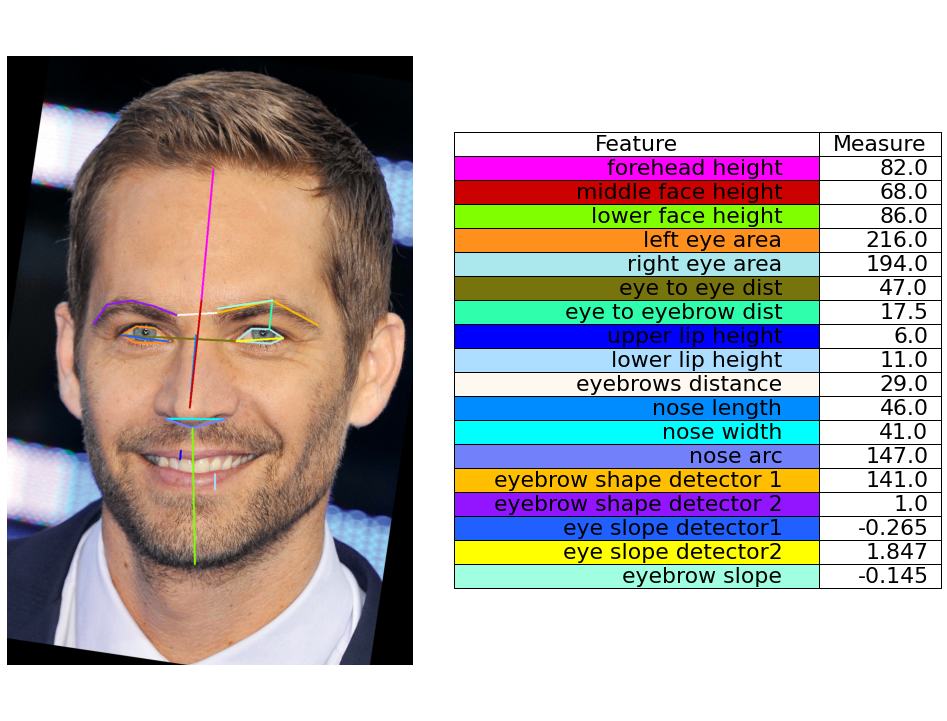

In [8]:
main()